<a href="https://colab.research.google.com/github/SethMinor/WSINDy4Weather/blob/main/geophysical_wsindy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weak SINDy with Geophysical Turbulence Data

##### Weak SINDy model discovery from [JHTDB stably stratified atmospheric boundary layer](https://turbulence.idies.jhu.edu/datasets/geophysicalTurbulence/sabl).

##### Python code written by Seth Minor, 2024. <br> Based on the [JCP paper by **D. A. Messenger**, **D. M. Bortz** 2021](https://www.sciencedirect.com/science/article/pii/S0021999121004204).

\begin{align*}
\begin{cases}
\boldsymbol{u}_t + (\boldsymbol{u}\cdot\nabla)\boldsymbol{u} = -\boldsymbol{f}\times(\boldsymbol{u}-\boldsymbol{u}_g) - \nabla p + \beta(\theta - \theta_0) - \nabla\cdot\mathbf{T},
\\
\theta_t + (\boldsymbol{u}\cdot\nabla)\theta = -\nabla\cdot\mathbf{B},
\\
\nabla\cdot\boldsymbol{u} = 0
\end{cases}
\quad \text{where} \quad
\begin{cases}
\text{T}_{ij} = \langle u'_iu_j' \rangle - u_iu_j,
\\
\text{B}_{i} = \langle u_i'\theta' \rangle - u_i\theta
\end{cases}
\end{align*}

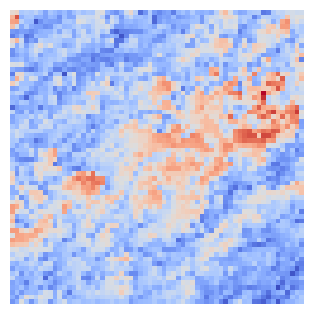

## Model Discovery

### Import Data

In [ ]:
# Access your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change directories
%cd /content/drive/My Drive/WSINDy/JHTDB/geophysical

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/WSINDy/JHTDB/geophysical


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools
import re

# Symbolic derivatives
%pip install symengine
import symengine as sp

# Progress bar
from tqdm.notebook import tqdm

# File path for empirical dataset
file_path = '/content/drive/My Drive/WSINDy/JHTDB/geophysical'

# Read in CSV data
U = np.loadtxt(file_path + '/u.csv', delimiter=',')
V = np.loadtxt(file_path + '/v.csv', delimiter=',')
#W = np.loadtxt(file_path + '/w.csv', delimiter=',')
#Wz = np.loadtxt(file_path + '/w_z.csv', delimiter=',')
Temp = np.loadtxt(file_path + '/temp.csv', delimiter=',')
#Tempz = np.loadtxt(file_path + '/temp_z.csv', delimiter=',')
Px = np.loadtxt(file_path + '/p_x.csv', delimiter=',')
Py = np.loadtxt(file_path + '/p_y.csv', delimiter=',')

# Convert to torch tensor
U = torch.tensor(U)
V = torch.tensor(V)
#W = torch.tensor(W)
#Wz = torch.tensor(Wz)
Temp = torch.tensor(Temp)
#Tempz = torch.tensor(Tempz)
Px = torch.tensor(Px)
Py = torch.tensor(Py)

# If necessary, also reshape to Nx x ... x Nt tensor
(Nx, Ny) = (62, 62)
U = U.view(Nx, Ny, -1)
V = V.view(Nx, Ny, -1)
#W = W.view(Nx, Ny, -1)
#Wz = Wz.view(Nx, Ny, -1)
Temp = Temp.view(Nx, Ny, -1)
#Tempz = Tempz.view(Nx, Ny, -1)
Px = Px.view(Nx, Ny, -1)
Py = Py.view(Nx, Ny, -1)

print(f"Imported tensors with shape {U.shape}")

# Space and time
x = torch.arange(0, Nx, 1)
y = torch.arange(0, Ny, 1)
t = torch.arange(0, 100*0.075, 0.075)

# Clear other variables
del Nx, Ny, file_path

Imported tensors with shape torch.Size([62, 62, 100])


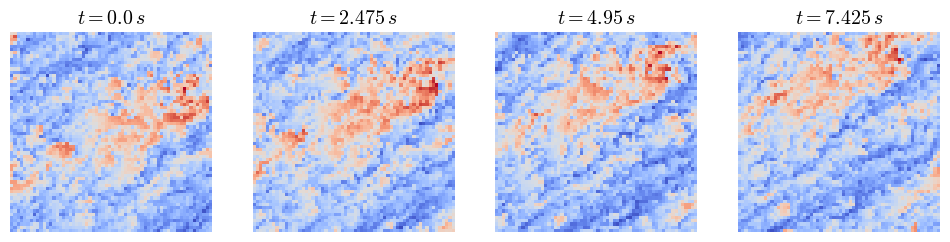

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12

# Plot
X,Y = np.meshgrid(x, y, indexing='ij')
fig,ax = plt.subplots(1,4, figsize=(12,2.6))

for i in range(4):
  thyme = i*33
  ax[i].pcolormesh(X, Y, Temp[:,:,thyme], cmap='coolwarm')
  ax[i].axis('off')
  ax[i].set_title(f'$t = {0.075 * thyme} \, s$')
plt.show()

del X,Y,thyme,fig,ax

### Helper Functions

#### Auto-Compute Hyperparameters

In [ ]:
# Two-piece linear approximation
def two_piece(x, x0, y0, m1, m2):
    return np.piecewise(x, [x<x0], [lambda x:m1*(x-x0)+y0, lambda x:m2*(x-x0)+y0])

# Define the scalar-valued function F(m)
def F(m,k,N,tau_hat,tau):
  log_term = np.log((2*m-1)/m**2)
  mid_term = (2*np.pi*k*m)**2 - 3*(tau_hat*N)**2
  last_term = 2*(tau_hat*N)**2 * np.log(tau)
  return log_term * mid_term - last_term

def optimal_support(U, d, two_piece, F, tau, tau_hat, **kwargs):
  # kwargs = {verbosity, init_guess}
  #---------------------------------------------------
  # verbosity = create plots? (0 or 1)
  # init_guess = [x0, y0, m1, m2], curve fitting guess
  #---------------------------------------------------

  # Check kwargs
  if 'verbosity' in kwargs:
    verbosity = kwargs['verbosity']
  else:
    verbosity = 0
  if 'init_guess' in kwargs:
    init_guess = kwargs['init_guess']
  elif d < (U.dim()-1):
    init_guess = [15, 1, 10, 0] # Space
  else:
    init_guess = [2, 1, 20, 0] # Time

  # FFT of U in one variable (e.g., x)
  Uhat_d = abs(torch.fft.rfft(U, n = U.shape[d], dim = d))

  # Average over others (e.g., t and y)
  dimmers = [dim for dim in range(Uhat_d.ndimension()) if dim != d]
  Uhat_d = Uhat_d.mean(dim = dimmers)

  # Cumulative sum
  Hd = torch.cumsum(Uhat_d, dim = 0)
  Hd = (Hd/Hd.max()).numpy() # Normalize for curve fitting

  # Run curve-fittting routine
  freqs = torch.arange(0, np.floor(U.shape[d]/2)+1, 1).numpy()
  params = scipy.optimize.curve_fit(two_piece, freqs, Hd, p0=init_guess)[0]

  # Grab critical wavenumber
  k = int(params[0])
  N = U.shape[d]

  # Redefine init_guess for the root finder
  init_guess = (np.sqrt(3)*N*tau_hat)/(2*np.pi*k)
  init_guess = init_guess * (1 + np.sqrt(1 - (8/np.sqrt(3))*np.log(tau)))/2

  # Use the root function to find the root
  md = int(scipy.optimize.root(F, init_guess, args=(k,N,tau_hat,tau)).x[0])

  if verbosity == 1:
    # Print optimal support value
    print(f'Optimal test function support is m={md} (d={d+1}).')

    # Plot the critical wavenumber
    plt.style.use('_mpl-gallery')
    plt.rcParams['figure.figsize'] = [3, 1]
    fig, ax = plt.subplots()
    ax.plot(freqs, Uhat_d, 'r--', label='$\mathcal{F}[U]$')
    ax.plot(freqs, Uhat_d.max()*Hd, 'k', label='$H^d$ (rescaled)')
    ax.plot(freqs,Uhat_d.max()*two_piece(freqs,*params),'g--',label='Piecewise Approx')
    ax.plot(params[0], Uhat_d.max()*params[1],'go')
    ax.set_xlabel('$k$')
    ax.set_title(f'Critical Wavenumber, $k_d=${k} ($d=${d+1})')
    plt.legend(loc = 'best')
    plt.show()

  # Return optimal support
  return md

In [ ]:
# Coordinate subsampling (x, y, or t)
def uniform_subsample(s, m, x):
  # Check size compatability
  if (2*m + 1) > x.shape[0]:
    raise Exception('Error: m produces non-compact support.')

  # Subsample
  xk = x[m:-m:s]

  # Compute indices of query points along given dimension
  indices = (x.unsqueeze(0) == xk.unsqueeze(1)).nonzero(as_tuple=True)[1]
  return indices.tolist()

# Apply 'mask' of subsampled query point indices to a given matrix
# (E.g., U[mask_rows, mask_cols] = Uk, as a vector)

def query_mask(U, s, m, X, D, **kwargs):
  # kwargs = {verbosity}
  #-------------------------------------------
  # verbosity = create plots? (0 or 1)
  #-------------------------------------------

  # Compute mask of query point indices
  subsamples = [uniform_subsample(s[i % len(s)], m[i % len(m)], X[i % len(X)]) for i in range(D+1)]
  my_mask = list(itertools.product(*subsamples))

  # Return mask
  mask = tuple(zip(*my_mask))

  # Optional plotting of query points
  if ('verbosity' in kwargs) and (kwargs['verbosity'] == 1):
    # Plot the first field, if multi-dimensional
    if type(U) is list:
      U0 = U[0]
    else:
      U0 = U.clone()

    if D == 1:
      X_mesh, T_mesh = torch.meshgrid(X[0], X[1], indexing='ij')
      Xk_mesh, Tk_mesh = torch.meshgrid(X[0][m[0]:-m[0]:s[0]], X[1][m[1]:-m[1]:s[1]], indexing='ij')

      plt.style.use('_mpl-gallery')
      plt.rcParams['figure.figsize'] = [4, 4]
      fig, ax = plt.subplots()
      ax.pcolormesh(T_mesh[:,:], X_mesh[:,:], U0[:,:])
      ax.scatter(Tk_mesh, Xk_mesh, color='red', s=3)
      ax.set_title('Query Points')
      ax.set_xlabel('$t$')
      ax.set_ylabel('$x$')
      print(f'\nQuery Points')
      plt.show()

    elif D == 2:
      X_mesh, Y_mesh = torch.meshgrid(X[0], X[1], indexing='ij')
      Xk_mesh, Yk_mesh = torch.meshgrid(X[0][m[0]:-m[0]:s[0]], X[1][m[1]:-m[1]:s[1]], indexing='ij')

      plt.style.use('_mpl-gallery')
      plt.rcParams['figure.figsize'] = [4, 4]
      fig, ax = plt.subplots()
      #ax.pcolormesh(X[0], X[1], U0[:,:,-1])
      ax.scatter(Xk_mesh.flatten(), Yk_mesh.flatten(), color='red', s=3)
      ax.set_title('Query Points')
      ax.set_xlabel('$x$')
      ax.set_ylabel('$y$')
      print(f'\nQuery Points')
      plt.show()

    elif D == 3:
      X_mesh, Y_mesh = torch.meshgrid(X[0], X[1], indexing='ij')
      Xk_mesh, Yk_mesh = torch.meshgrid(X[0][m[0]:-m[0]:s[0]], X[1][m[1]:-m[1]:s[1]], indexing='ij')

      plt.style.use('_mpl-gallery')
      plt.rcParams['figure.figsize'] = [4, 4]
      fig, ax = plt.subplots()
      ax.pcolormesh(X_mesh[:,:], Y_mesh[:,:], U0[:,:,0,-1])
      ax.scatter(Xk_mesh, Yk_mesh, color='red', s=3)
      ax.set_title('Query Points, at $z=0$')
      ax.set_xlabel('$x$')
      ax.set_ylabel('$y$')
      print(f'\nQuery Points')
      plt.show()

  # Return
  return mask

#### Create Test Functions

In [ ]:
# Calculate symbolic derivatives

def D_phibar(x, D, x_sym, phi_bar):
  # Dth derivative at degree p
  D_phi = sp.diff(phi_bar, x_sym, D)

  # Evaluate at point x
  if abs(x) < 1:
    return float(D_phi.subs(x_sym, x))
  else:
    return 0.0

In [ ]:
def get_test_fcns(m, tau, x, alpha, d, D, **kwargs):
  # kwargs = {dx, p, scales, verbosity}
  #----------------------------------------
  # dx = space or time discretization
  # p = known degree for test fcns
  # scales = scale factors ([yu], [yx], yt)
  # verbosity = create plots? (0 or 1)
  #----------------------------------------

  # Number of points in x_d coordinate
  N = x.shape[0]

  # Check if dx (or dt) were provided
  if 'dx' in kwargs:
    dx = kwargs['dx']
  else:
    dx = (x[1] - x[0]).item()

  # Check if scaling factors were provided
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    d_scale = (yx + [yt])[d]
    dx = d_scale * dx

  # Check size compatibility of support m
  if (m > (N-1)/2) or (m <= 1):
    raise Exception('Error: test fcn not compactly supported.')

  # Check if a known p was provided
  if 'p' in kwargs:
    p = kwargs['p']
  else:
    # Solve minimization problem for degree p
    alpha_bar = max(tuple(item[d] for item in alpha))
    log_tau_term = np.ceil(np.log(tau)/np.log((2*m-1)/m**2))
    p = max(log_tau_term, alpha_bar + 1)

  # Initialize grid of discretized test fcn values
  test_fcns_d = torch.zeros(len(alpha), 2*m+1, dtype = x.dtype)
  n_grid = torch.arange(-1, 1.0001, 1/m, dtype = x.dtype)

  # Multi-index values (a_d^i) given d, for i=0,...,S
  multi_index_d = tuple(item[d] for item in alpha)

  # Precompute symbolic derivative variables
  x_sym = sp.Symbol('x')
  phi_bar = (1 - x_sym**2)**p
  vec = np.vectorize(D_phibar)

  # Compute D^i derivative of phi_d (given d), for i=0,...,S
  for i in range(len(alpha)):
    # Speed-up: check for repeated values
    if (i > 0) and (multi_index_d[i-1] == multi_index_d[i]):
      test_fcns_d[i,:] += test_fcns_d[i-1,:]
    else:
      # Get multi-index value (a_d^i)
      num_derivs = multi_index_d[i]

      # Evaluate the (a_d^i) derivative on n_grid
      A_i = torch.from_numpy(vec(n_grid, num_derivs, x_sym, phi_bar))

      # Add the rescaled D^i derivative to the grid of values
      test_fcns_d[i,:] += (1/((m*dx)**num_derivs)) * A_i

  # Optional plotting of some test functions
  if ('verbosity' in kwargs) and (kwargs['verbosity'] == 1) and (d == 0):
    # Scaled test function grid
    y_grid = d_scale* torch.arange(-m*dx, m*dx+0.0001, dx)

    plt.style.use('_mpl-gallery')
    plt.rcParams['figure.figsize'] = [3, 1]
    fig, ax = plt.subplots()

    ax.plot(y_grid, test_fcns_d[1,:], label = '$i=2$')

    ax.set_title('An example $\mathcal{D}^i\psi$ component')
    ax.set_xlabel('$y = x_k - x$')
    ax.set_ylabel('${\phi_x}^{(a_x^i)} (y)$')
    plt.legend(loc = 'upper left')
    print(f'\nTest Functions')
    plt.show()

  # Return test function derivatives
  return test_fcns_d

In [ ]:
# Speedy Test Function Creation
# Checks for and exploits redundancy in derivative library.

def speedy_test_fcns(m, p, tau, X, dX, alpha, D, **kwargs):
  # kwargs = {scales, verbosity}
  #----------------------------------------
  # scales = scale factors ([yu], [yx], yt)
  # verbosity = create plots? (0 or 1)
  #----------------------------------------

  # Initialize test functions
  test_fcns = []

  # The speed-up only makes sense for D > 1 and equal spatial m,p values
  m_check = all([m[0] == m[n] for n in range(D)])
  p_check = all([p[0] == p[n] for n in range(D)])

  # Checking whether it makes sense to try the speed-up
  if (D == 1) or (m_check * p_check == False):
    go_condition = False
  else:
    try:
      # Building a condition to indicate if alpha is listed sequentially
      # THIS IS NOT FOOL-PROOF
      (a0, a1) = ([elem[0] for elem in alpha], [elem[1] for elem in alpha])
      a_max = max(a0)
      go_condition = (a0[2:2+a_max] == a1[2+a_max:2+2*a_max])
    except:
      # In case this throws an error due to a weird alpha structure
      if ('verbosity' in kwargs) and (kwargs['verbosity']==1):
        print('\nDerivative library not given in a sequential order.')
      go_condition = False

  # If the conditions aren't right, return the usual slow computation
  if (go_condition == False):
    if ('verbosity' in kwargs) and (kwargs['verbosity']==1):
      print('\nUsing slow test function method...\n')
    for d in range(D + 1):
      (kwargs['dx'], kwargs['p']) = (dX[d], p[d])
      test_fcns.append(get_test_fcns(m[d], tau, X[d], alpha, d, D, **kwargs))
    return test_fcns

  # Otherwise, perform fast computation exploiting redundant derivatives
  else:
    if ('verbosity' in kwargs) and (kwargs['verbosity']==1):
      print("\nSequential 'alpha' detected. Using fast test function method...")

    # Index after which mixed/'cross' derivatives would start (if present)
    c_i = 2 + D*a_max

    # Maximum cross derivative
    if c_i < len(alpha):
      c_max = max([elem[0] for elem in alpha[c_i:]])

    # Define a permutation that allows computation of step (d+1) from step (d)
    # This takes indices [0,1,...,S-1] --> [block_1, block_2, block_3]
    normal_inds = [ind for ind in range(len(alpha))]

    # Block 1: the first two indices are fixed (D0 and D1)
    block_1 = normal_inds[0:2]

    # Block 2: pure derivative terms are shifted cyclically
    block_2 = normal_inds[2:c_i]
    block_2 = block_2[-a_max:] + block_2[0:-a_max]

    # Block 3: cross derivative terms are 'cut' and 'stretched'
    # (Note: this permutation is dependent of the value of 'd'.)
    block_3 = normal_inds[c_i:]
    if block_3 == []:
      # No cross derivatives are present
      block_3 = [[] for d in range(D-1)]
    else:
      # Cut and stretch the first '(d+1)*cross_max' variables over 'block_3'
      b3 = c_max**(D-2)
      block_3 = [(b3//(d+1))*[c_max*[ind] for ind in block_3[0:(d+1)*c_max]] for d in range(D-1)]
      block_3 = [[ind for elem in block_3[d] for ind in elem] for d in range(D-1)]

    # Compute the first and last test function
    tf_1 = get_test_fcns(m[0], tau, X[0], alpha, 0, D, **kwargs)
    test_fcns.append(tf_1)
    tf_d = tf_1 # The d^th test function
    tf_t = get_test_fcns(m[-1], tau, X[-1], alpha, D, D, **kwargs)

    # Use permuted indices to automatically compute the other test functions
    for d in range(1, D):
      perm_inds = block_1 + block_2 + block_3[d-1]
      tf_d = tf_d[perm_inds,:]

      # Rescale if needed
      if dX[0] != dX[d]:
        if d == 1:
          ad = a0
        elif d == 2:
          ad = a1
        else:
          ad = [elem[d-1] for elem in alpha]
        ad = torch.tensor(ad, dtype=tf_d.dtype).view(-1, 1)
        tf_d *= (dX[d-1]/dX[d])**ad

      # Add to list of test functions
      test_fcns.append(tf_d)

    # Add the temporal test function and return the list
    test_fcns.append(tf_t)
    return test_fcns

#### Rescaling the Data

In [ ]:
# Carefully compute n-choose-k with non-integer k
def my_nchoosek(n, k):
  n_factorial = scipy.special.factorial(n)
  k_factorial = scipy.special.factorial(np.ceil(k))
  nk_term = scipy.special.factorial(n-np.floor(k))
  return n_factorial / (nk_term * k_factorial)

# Automatically compute scaling factors
# Expects U as a list, [U1,...,Un]

def get_scales(fj, alpha, U, m, dX, p, **kwargs):
  # kwargs = {scales}
  #---------------------------------------
  # scales = known scales ([yu], [yx], yt)
  #---------------------------------------

  # Get number of spatial dimensions
  D = len(dX[:-1])

  # Check if known scales were provided
  if ('scales' in kwargs):
    # Expects yu and yx as lists
    (yu, yx, yt) = kwargs['scales']

  # Otherwise, compute scales
  else:
    # Maximum monomial power in library
    beta_bar = 0
    for n in range(len(U)):
      max_n = max(tuple(item[n] for item in fj['poly']))
      beta_bar = max(beta_bar, max_n)

    # Find maximum spatial derivative
    alpha_bar_x = []
    for d in range(len(alpha[0]) - 1):
      max_d = max(tuple(item[d] for item in alpha))
      alpha_bar_x.append(max_d)

    # Find maximum temporal derivative
    alpha_bar_t = max(tuple(item[-1] for item in alpha))

    # Compute L^2 norm of U and U^beta as vectors
    U_2 = [torch.linalg.norm(torch.reshape(u, (-1,))).item() for u in U]
    U_beta = [torch.linalg.norm(torch.reshape(u**beta_bar, (-1,))).item() for u in U]
    yu = [(U_2[n]/U_beta[n])**(1/beta_bar) for n in range(len(U))]

    # Compute scales using ansatz given in paper
    yx = [(1/(m[d]*dX[d])) * (my_nchoosek(p[d], alpha_bar_x[d]/2)
          *scipy.special.factorial(alpha_bar_x[d]))**(1/alpha_bar_x[d]) for d in range(D)]
    yt = (1/(m[-1]*dX[-1])) * (my_nchoosek(p[-1], alpha_bar_t/2)
          *scipy.special.factorial(alpha_bar_t))**(1/alpha_bar_t)

  # Compute scale matrix, M = diag(mu)
  # Dimensions are K x SJ, where J=|{fj}|
  # (Note: extra y_un scaling factors for each field Un are dealt with in MSTLS.)
  # TO DO: GENERALIZE FOR TRIG FCNS, ETC.
  mu = torch.zeros((len(alpha)-1) * len(fj['poly']), dtype=U[0].dtype)

  for j in range(len(fj['poly'])):
    for i in range(1, len(alpha)):

      # Exclude derivatives of constants
      if (j == 0) and (i > 1):
        pass
      else:
        # Exponents for [yx], yt
        yx_exps = [yx[d]**(alpha[0][d] - alpha[i][d]) for d in range(D)]
        yx_term = np.prod(yx_exps) # Take product of x-scales
        t_exp = alpha[0][-1] - alpha[i][-1]

        # Take product of u-scales
        yu_term = [yu[n]**(fj['poly'][j][n]) for n in range(len(U))]
        yu_term = np.prod(yu_term)

        # Set corresponding mu value
        mu[(i-1)*len(fj['poly']) + j] = yu_term * yx_term * (yt**t_exp)

  # Make diagonal matrix
  M = torch.diag(mu)

  # Remove skipped columns (derivatives of constants)
  cols_to_remove = [len(fj['poly'])*c for c in range(1,len(alpha)-1)]
  Lib_mask = torch.ones(M.shape[1], dtype=torch.bool)
  Lib_mask[cols_to_remove] = False
  M = torch.diag(M[Lib_mask, Lib_mask])

  # Return scales and scale matrix
  return yu, yx, yt, M

#### Create the LHS

In [ ]:
# Compute the LHS vector b
def create_b(U, test_fcns, dX, mask, D, **kwargs):
  # kwargs = {scales}
  #----------------------------------------
  # scales = scale factors ([yu], [yx], yt)
  #----------------------------------------

  # Check if scaling factors were provided
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    (U_, dX_) = (yu*U, [yx[d]*dX[d] for d in range(D)]+[yt*dX[-1]])
  else:
    (U_, dX_) = (U, dX)

  # Temporarily convert test functions to numpy arrays
  test_fcns_ = [test_fcn.numpy() for test_fcn in test_fcns]
  U_ = U_.numpy()

  # Convolve test function derivatives with data
  conv = U_
  for d in range(D+1):
    # Reshape test function appropriately
    slicing = [None] * len(test_fcns)
    slicing[d] = slice(None)

    # 1D convolution along the d-th axis
    conv = scipy.signal.convolve(conv, test_fcns_[d][tuple(slicing)], mode='same')

  # Convert back to pytorch tensor
  b = np.prod(dX_)*(torch.from_numpy(conv))

  # Convert to column vector and return
  b = (b[mask]).reshape(-1,1)
  return b

#### Create the Model Library

In [ ]:
# Evaluate library functions {fj} on data
# Expects U as a list, U=[U1,...,Un]
# If auxiliary fields exist, expects U=[...,V1,...,Vm]
# (Note: j is 1-indexed here, so input j=1,...,J.)

def evaluate_fj(name, fj, j, U):
  # Monomial function for any number of fields (U1,...,Un)
  if name == 'poly':
    # Evaluate jth monomial, e.g., (u1)^3*(u2)^2
    fj_of_U_ = [(U[n]**fj[name][j-1][n]).numpy() for n in range(len(U))]
    fj_of_U_ = torch.from_numpy(np.prod(fj_of_U_, axis=0))

  # Sinus/cosinus for a single field u(x,t)
  elif name == 'trig':
    raise Exception('Trig functions not currently supported!')
    # Evaluate jth frequency [0], phase [1]
    #fj_of_U_ = np.sin(fj[name][j-1][0]*U + fj[name][j-1][1])

  # In case the given function is not defined
  else:
    raise Exception(f'Function "{name}" was not found.')

  # Return fj evaluated on data
  return fj_of_U_

In [ ]:
# Compute column of model library
# (Evaluated for specific i,j)

def get_library_column(fj_of_U, test_fcns, dX, mask, D, **kwargs):
  # kwargs = {scales}
  #----------------------------------------
  # scales = scale factors ([yu], [yx], yt)
  #----------------------------------------

  # Check if scaling factors were provided
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    dX_ = [yx[d]*dX[d] for d in range(D)] + [yt*dX[-1]]
  else:
    dX_ = dX

  # Temporarily convert test functions to numpy arrays
  test_fcns_ = [test_fcn.numpy() for test_fcn in test_fcns]
  fj_of_U_ = fj_of_U.numpy()

  # Convolve test function derivatives with data
  conv = fj_of_U_
  for d in range(D+1):
    # Reshape test function appropriately
    slicer = [None] * len(test_fcns)
    slicer[d] = slice(None)

    # 1D convolution along the d-th axis
    conv = scipy.signal.convolve(conv, test_fcns_[d][tuple(slicer)], mode='same')

  # Convert back to pytorch tensor
  Lij_matrix = np.prod(dX_)*(torch.from_numpy(conv))

  # Convert to column vector over query points and return
  Lij = (Lij_matrix[mask]).reshape(-1,1)
  return Lij

In [ ]:
# Create the entire model library L
# Expects U as a list, U=[U1,...,Un]

def create_L(U, test_fcns, dX, mask, D, alpha, fj, **kwargs):
  # kwargs = {scales, aux_fields, augment, field_names, mu_augment}
  #----------------------------------------------------------------
  # scales = scale factors ([yu], [yx], yt)
  # aux_fields = extra library variables [V1,...,Vm]
  # augment = append operator? E.g., ('Div','2d_cartesian')
  # field_names = variable names, e.g., ['u','v','w']
  # mu_augment = diagonal of scaling matrix for augmented terms
  #----------------------------------------------------------------

  #Initialize library variables
  col_kwargs = {}
  U_ = [u.clone() for u in U]

  # Check if scaling factors were provided
  if 'scales' in kwargs:
    (yu, yx, yt) = kwargs['scales']
    col_kwargs['scales'] = (yu, yx, yt)

    # Rescale each field
    for n in range(len(yu)):
      U_[n] *= yu[n]

  # Check for extra variables
  if 'aux_fields' in kwargs:
    aux_fields = kwargs['aux_fields']
  else:
    aux_fields = []
  # Note: auxiliary fields come pre-scaled
  U_ += aux_fields

  # Create function names
  fj_names = ['poly']*len(fj['poly']) + ['trig']*len(fj['trig'])

  # The library is a K x SJ matrix
  (K, S, J) = (len(mask[0]), len(alpha)-1, sum(len(fcn) for fcn in fj.values()))
  L = torch.zeros(K, S*J, dtype=U[0].dtype)

  # Loop over all functions {fj}
  for j in tqdm(range(1, J+1)): # Progress bar
    # Compute fj(U)
    name = fj_names[j-1]
    fj_of_U = evaluate_fj(name, fj, j, U_)

    # Loop over all derivatives D^i
    for i in range(1, S+1):
      # Exclude derivatives of constants
      # (These are the D^i[f_1] for i=2,...,S terms)
      if (name == 'poly') and (j == 1) and (i > 1):
        pass
      else:
        # Get the corresponding test functions
        test_fcns_i = [test_fcn[i,:] for test_fcn in test_fcns]

        # Compute corresponding library column
        fj_of_U_ = fj_of_U.clone()

        # Check if GPU is available
        if torch.cuda.is_available() and (D < 3):
          # GENERALIZE GPU CONVS TO ARB DIMENSION
          #Lij = get_library_column_gpu(fj_of_U_, test_fcns_i, dX, mask, D, **col_kwargs)
          print('CUDA not currently supported.')
          Lij = get_library_column(fj_of_U_, test_fcns_i, dX, mask, D, **col_kwargs)
        else:
          Lij = get_library_column(fj_of_U_, test_fcns_i, dX, mask, D, **col_kwargs)
        L[:, (i-1)*J + j-1] = Lij[:, 0]

  # Remove skipped columns
  cols_to_remove = [len(fj['poly'])*c for c in range(1, S)]
  Lib_mask = torch.ones(L.shape[1], dtype=torch.bool)
  Lib_mask[cols_to_remove] = False
  L = L[:, Lib_mask]

  # Augment the library, if necessary
  if 'augment' in kwargs:
    augment = kwargs['augment']
    aug_dict = {'aux_fields' : aux_fields}
    if 'mu_augment' in kwargs:
      aug_dict['mu_augment'] = kwargs['mu_augment']
    else:
      raise Exception('Create_L: augmented terms require a scaling matrix.')
    if 'field_names' in kwargs:
      aug_dict['field_names'] = kwargs['field_names']
    L, aug_columns = augment_library(augment, L, U, fj, alpha, D, **aug_dict)
  else:
    # Indices used to create augmented matrix
    aug_columns = None

  # Return complete model library
  return L, aug_columns

#### MSTLS Optimization

In [ ]:
# Computes loss for a given candidate threshold
def loss(w_lambda, w_LS, L):
  # Least squares term
  LS_num = torch.linalg.norm(torch.matmul(L, w_lambda-w_LS)).item()
  LS_denom = torch.linalg.norm(torch.matmul(L, w_LS)).item()
  LS_term = LS_num / LS_denom

  # Zero norm term
  zero_norm = sum(w_lambda != 0).item()/w_lambda.shape[0]

  # Return total loss(lambda_n)
  loss_n = LS_term + zero_norm
  return loss_n

In [ ]:
# MSTLS inner loop
# (Expects that L and b are rescaled.)

def MSTLS_iterate(L, b, lambda_n, **kwargs):
  # kwargs = {w_LS, M, max_its, sparsify, yu_n, augment, aug_columns}
  #------------------------------------------------------------------
  # w_LS = precomputed LS solution
  # M = scale matrix, with w = M * w_tilde
  # max_its = maximum number of iterations
  # sparsify = 'original' or 'scaled' data
  # yu_n = unique rescaling factor for field Un
  # augment = append operator? E.g., ('Div','2d_cartesian')
  # aug_columns = indices of library columns used for augment
  #------------------------------------------------------------------

  # Check MSTLS hyperparameters
  # Maximum iterations
  if 'max_its' in kwargs:
    max_its = kwargs['max_its']
  else:
    max_its = L.shape[1]

  # Sparsification data for thresholding
  if 'sparsify' in kwargs:
    sparsify = kwargs['sparsify']
  else:
    # By default, enforce sparsity on scaled data
    #sparsify = 'original'
    sparsify = 'scaled'

  # Scaling matrix
  if 'M' in kwargs:
    M = kwargs['M']
  #elif ('M' not in kwargs) and (sparsify == 'original'):
  elif 'M' not in kwargs:
    # Could consider setting M = identity otherwise?
    raise Exception('\nMSTLS_iterate: scale matrix currently required.')

  # Unique scaling factor yu_n
  if 'yu_n' in kwargs:
    yu_n = kwargs['yu_n']
  else:
    # Set to unit scaling
    yu_n = 1

  # Diagonal of the true scaling matrix M = diag(mu)
  mu = (1/yu_n) * torch.diag(M).unsqueeze(1)

  # For augmented libraries, 'mu' must be modified to rescale additional columns
  if 'aug_columns' in kwargs:
    aug_columns = kwargs['aug_columns']
  else:
    aug_columns = None
  if ('augment' in kwargs) and (aug_columns is not None):
    # Need to pad mu with '1/yu_n'
    mu_extra = (1/yu_n)*torch.ones(1,1)
    mu = torch.cat((mu, mu_extra))

  # Check if precomputed LS solution exists
  if 'w_LS' in kwargs:
    w_LS_ = kwargs['w_LS'].clone()
  # Otherwise, compute it
  else:
    w_LS_ = torch.linalg.lstsq(L, b, driver='gelsd').solution

  # Undo scaling if necessary
  if sparsify == 'original':
    w_LS_ = mu * w_LS_ # Unscale LS weights

  # Compute |b|/|Li| bounds for all columns
  norm_b = torch.linalg.norm(b)
  norm_Li = torch.linalg.norm(L,dim=0)
  bounds = norm_b / norm_Li

  # Rescale the bounds if necessary
  if sparsify == 'original':
    bounds = bounds * mu.squeeze(1)

  # Define upper and lower bounds (lambda thresholding)
  L_bounds = lambda_n*torch.maximum(bounds,torch.ones(bounds.shape[0]))
  U_bounds = (1/lambda_n)*torch.minimum(bounds,torch.ones(bounds.shape[0]))

  # Begin applying iterative thresholding on elements of weight vector
  iteration = 0
  w_n = w_LS_.clone()
  inds_old = torch.tensor([0])
  while iteration <= max_its:
    # Find in-bound and out-of-bound indices and set them to zero
    ib_inds = torch.where((abs(w_n[:,0])>=L_bounds)&(abs(w_n[:,0])<=U_bounds))[0]
    oob_inds = torch.where((abs(w_n[:,0])<L_bounds)|(abs(w_n[:,0])>U_bounds))[0]

    # Check stopping condition
    if (torch.equal(inds_old, ib_inds) and iteration!=0) or (ib_inds.shape[0]==0):
      break

    # Find LS solution amongst sparser, in-bound indices
    w_n[ib_inds] = torch.linalg.lstsq(L[:,ib_inds], b, driver='gelsd').solution
    # Mask oob columns of L
    w_n[oob_inds] = 0

    # Unscale sparse solution if needed
    if sparsify == 'original':
      w_n = mu * w_n # Unscaled weights

    # Update loop variables
    inds_old = ib_inds
    iteration += 1
    if iteration == max_its:
      print('MSTLS reached the maximum number of iterations allowed.')

  # Evaluate the loss function on the resulting weights
  # (MSTLS loss is computed on scaled data, but returns unscaled weights.)
  if sparsify == 'original':
    # For loss, change original weights to scaled weights
    loss_n = loss((1/mu)*w_n, (1/mu)*w_LS_, L)
  elif sparsify == 'scaled':
    loss_n = loss(w_n, w_LS_, L) # Compute loss on scaled weights
    w_n = mu * w_n # Return unscaled weights
  else:
    raise Exception("Sparsify must be set to either 'original' or 'scaled'.")
  return w_n, loss_n

In [ ]:
# Full MSTLS optimization, minimizing loss
def MSTLS(L, b, lambdas, **kwargs):
  # kwargs = {threshold, w_LS, M, max_its, sparsify, yus, augment, aug_columns}
  #----------------------------------------------------------------------------
  # threshold = known optimal threshold
  # w_LS = precomputed LS solution
  # M = scale matrix (according to paper)
  # max_its = maximum number of iterations
  # sparsify = 'original' or 'scaled' data
  # yus = [yu_n]'s, unique rescaling factor for field Un
  # augment = append operator? E.g., ('Div','2d_cartesian')
  # aug_columns = indices of library columns used for augment
  #----------------------------------------------------------------------------

  # If needed, cast L,b to common data type
  if b.dtype != L.dtype:
    b.to(torch.float64) # LHS
    L.to(torch.float64) # RHS

  # --- Checking MSTLS hyperparameters ---
  loop_dict = {}
  # Maximum number of iterations
  if 'max_its' in kwargs:
    loop_dict['max_its'] = kwargs['max_its']
  else:
    loop_dict['max_its'] = L.shape[1]
  # Which data to sparsify
  if 'sparsify' in kwargs:
    loop_dict['sparsify'] = kwargs['sparsify']
  # Scaling matrix
  if 'M' in kwargs:
    loop_dict['M'] = kwargs['M']
  # Unique scaling factors [yu_n]
  if 'yus' in kwargs:
    yus = kwargs['yus']
  else:
    # Set to unit scaling
    yus = [1] * b.shape[1]
  # Check if precomputed LS solution exists
  if 'w_LS' in kwargs:
    w_LS_ = kwargs['w_LS']
  else:
    w_LS_ = torch.linalg.lstsq(L,b, driver='gelsd').solution
  # Check if library is augmented
  if 'augment' in kwargs:
    loop_dict['augment'] = kwargs['augment']
  if 'aug_columns' in kwargs:
    loop_dict['aug_columns'] = kwargs['aug_columns']
  # --------------------------------------

  # Check if known optimal threshold was provided
  # (Note: this should be a list corresponding to [U1,...,Un].)
  if 'threshold' in kwargs:
    lambda_stars = kwargs['threshold']

  # Otherwise, iterate to find the optimal theshold 'lambda_star'
  else:
    # If multidimensional, iterate over each field
    lambda_stars = []

    for n in range(w_LS_.shape[1]):
      loop_dict['yu_n'] = yus[n] # Unique scaling factor yu_n
      loop_dict['w_LS'] = w_LS_[:,n].reshape(-1,1)
      b_n = b[:,n].reshape(-1,1)
      loss_history = []

      for lambda_n in lambdas:
        # Compute candidate weights and evaluate loss
        w_n, loss_n = MSTLS_iterate(L, b_n, lambda_n.item(), **loop_dict)
        loss_history.append(loss_n)

      # Find optimal candidate threshold for each field Un
      # (Automatically finds smallest minimzer, if not unique)
      ind_star = loss_history.index(min(loss_history))
      lambda_star = lambdas[ind_star].item()
      lambda_stars.append(lambda_star)

  # Use the optimal threshold to compute the final sparse weights
  w_stars = []
  loss_stars = []

  # Again, iterate over each field U=[U1,...,Un]
  for n in range(w_LS_.shape[1]):
    loop_dict['yu_n'] = yus[n] # Unique scaling factor yu_n
    loop_dict['w_LS'] = w_LS_[:,n].reshape(-1,1)
    b_n = b[:,n].reshape(-1,1)
    lambda_star = lambda_stars[n]

    w_star_, loss_star_ = MSTLS_iterate(L, b_n, lambda_star, **loop_dict)
    w_stars.append(w_star_)
    loss_stars.append(loss_star_)

  # Return final result
  w_star_ = torch.cat(w_stars, 1)
  return w_star_, lambda_stars, loss_stars

#### Print the Results

In [ ]:
# Prints a report of the WSINDy run.

def print_report(**kwargs):
  # kwargs = {verbosity, thresh, Loss, L, scales, sparsify, p, s}
  #--------------------------------------------------------------
  # verbosity = create plots? (0 or 1)
  # thresh = optimal MSTLS threshold(s)
  # Loss = minimum MSTLS loss value
  # L = model library
  # scales = scale factors ([yu's], yx, yt)
  # aux_scales = scaling factors for aux fields
  # sparsify = use 'original' or 'scaled' data in MSTLS
  # p = test function degrees
  # s = query point subsampling rates
  #--------------------------------------------------------------

  if 'verbosity' not in kwargs:
    return

  elif kwargs['verbosity'] == 1:

    # Check if GPU was utilized
    if torch.cuda.is_available():
      print(f'\nLibrary computed with CUDA ({torch.cuda.get_device_name()}).')
    else:
      print(f'\nLibrary computed with CPU.')

    # Report if scaled or unscaled data was used for thresholding
    if 'sparsify' in kwargs:
      sparsify = kwargs['sparsify']
      print(f'The {sparsify} data was used for MSTLS thresholding.')

    if 'thresh' and 'Loss' in kwargs:
      # Print optimal MSTLS parameters
      (thresh, Loss) = (kwargs['thresh'], kwargs['Loss'])
      print(f'\nOptimal threshold(s) = {[round(th,3) for th in thresh]}')
      print(f'Optimal loss(es) = {[round(lo,3) for lo in Loss]}')

    if 'L' and 'scales' and 'aux_scales' and 'p' and 's' in kwargs:
      (scales, aux_scales) = (kwargs['scales'], kwargs['aux_scales'])
      (L, p, s) = (kwargs['L'], kwargs['p'], kwargs['s'])
      print(f'\nLibrary shape: {L.shape[0]} x {L.shape[1]}')
      condL = torch.linalg.cond(L,p=2).item()
      print(f'Library condition number: {"{:0.3e}".format(condL)}.')
      scales_ = [[round(sc,3) for sc in scales[0]]]
      scales_ += [[round(sc,3) for sc in scales[1]]]
      scales_ += [round(scales[2],3)]
      print(f'scales = {scales_}')
      print(f'aux_scales = {[round(asc,3) for asc in aux_scales]}')
      print(f'p = {p}')
      print(f's = {s}')

    return

In [ ]:
# Returns a string for each possible term in the model library.
# (Expects U as a list, U=[U1,...,Un].)
# (Note: not currently compatible with trig functions.)

def get_term_names(U, fj, alpha, D, **kwargs):
  # kwargs = {aux_fields, field_names, augment}
  #--------------------------------------------------------
  # aux_fields = extra library variables [V1,...,Vm]
  # field_names = variable names, e.g., ['u','v','w']
  # augment = append operator? E.g., ('Div','2d_cartesian')
  #--------------------------------------------------------

  # Check if extra variables were provided
  if 'aux_fields' in kwargs:
    aux_fields = kwargs['aux_fields']
  else:
    aux_fields = []
  U_ = U + aux_fields

  # --- Formatting derivative library as a list of strings ---
  alpha_names = []
  for elem in alpha:
    if all(value == 0 for value in elem):
      alpha_names.append('')
    else:
      # 1D, 2D, 3D case-handling
      if D == 1:
        alpha_names.append('_'+'t'*elem[1]+'x'*elem[0])
      elif D == 2:
        alpha_names.append('_'+'t'*elem[2]+'x'*elem[0]+'y'*elem[1])
      elif D == 3:
        alpha_names.append('_'+'t'*elem[3]+'x'*elem[0]+'y'*elem[1]+'z'*elem[2])
      # General case
      else:
        string = [('x' + str(n+1) + ',')*elem[n] for n in range(len(elem)-1)]
        string = ('_'+'t,'*elem[3] + ''.join(string)).rstrip(',')
        alpha_names.append(string)

  # --- Creating term names (e.g., 'u_t', 'u_x' etc.) ---
  if 'field_names' in kwargs:
    # Use custom field names (single characters)
    field_names = kwargs['field_names'][0:len(U_)]
    pattern = r'.(?=\^0)..' # Regular expression pattern
  else:
    # Use variable names 'u1', 'u2', etc.
    field_names = ['u' + str(n+1) for n in range(len(U_))]
    pattern = r'..(?=\^0)..' # Regular expression pattern

  # Combining derivatives with field names
  LHS_names = [str(u) + alpha_names[0] for u in field_names] # D^0 operator name
  # Adding exponent symbols
  RHS = [field_names[n] + '^' + str(fj['poly'][elem][n])
         for elem in range(len(fj['poly'])) for n in range(len(U_))]
  # Combining the names of cross-multiplied terms
  RHS = [''.join(RHS[i:i+len(U_)]) for i in range(0, len(RHS), len(U_))]
  RHS = ['(' + elem + ')' for elem in RHS] # Parentheses
  RHS = [u + Di for Di in alpha_names[1:] for u in RHS] # Partial deriv notation

  # Remove skipped terms
  remove = [len(fj['poly'])*c for c in range(1,len(alpha)-1)]
  RHS_names = [term for col, term in enumerate(RHS) if col not in remove]

  # Replace 'un^0' terms by either '1' (first term) or '' (other terms)
  RHS_names = ['1'] + [re.sub(pattern, '', string) for string in RHS_names[1:]]

  # Also replace '^1' terms by ''
  RHS_names = [string.replace('^1','') for string in RHS_names]

  # Add names of augmented library columns, if necessary
  if 'augment' in kwargs:
    operator = kwargs['augment'][0]
    if operator in ['Div','Advection']: # List of supported operators
      if operator == 'Div': # Divergence, ∇•(φ𝘂)
        # Assumes 'field_names' is ordered ['φ',...]
        op_name = '∇•('+field_names[0]+'𝘂)'
        RHS_names.append(op_name)
      elif operator == 'Advection': # Advection, (𝘂•∇)φ
        # Assumes 'field_names' is ordered ['φ',...]
        op_name = '(𝘂•∇)'+field_names[0]
        RHS_names.append(op_name)
    else:
      raise Exception(f'get_term_names: {operator} symbol not yet supported.')

  term_names = (LHS_names, RHS_names)
  return term_names

In [ ]:
# Get discovered PDE model symbolically, as a string.

def get_model(w, term_names):
  # Split into LHS and RHS
  (LHS_names, RHS_names) = term_names

  # Find nonzero RHS terms
  inds = [torch.nonzero(w[:,n])[:,0].tolist() for n in range(w.shape[1])]

  # Append terms onto model
  model = []
  for n in range(w.shape[1]):
    terms_n = ['({0:.2f})'.format(w[ind,n].item())+RHS_names[ind] for ind in inds[n]]

    # Add to evolution operator
    model_n = LHS_names[n] + ' = ' + ' + '.join(terms_n)
    model.append(model_n)

  # Collapse to a single string and return
  model = '\n'.join(model)
  return model

#### Kwarg Handling

In [ ]:
def kwarg_handling(U, alpha, **kwargs):

  # WSINDy Kwarg Handling Function
  # This function manages the following hyperparameters:
  #--------------------------------------------------------
  # PDE PARAMETERS
  # x = spatial domain(s)
  # dx = spatial discretization(s)
  # t = temporal domain
  # dt = temporal discretization
  # aux_fields = extra variables for term library
  # aux_scales = scaling factors for auxiliary fields
  #
  # WEAK SINDY HYPERPARAMETERS
  # m = explicit (mx,...,mt) values
  # s = explicit (sx,...,st) values
  # lambdas = MSTLS threshold search space
  # threshold = known optimal threshold
  # p = explicit (px,...,pt) values
  # tau = test function tolerance
  # tau_hat = Fourier test function tolerance
  # scales = explicit ([yu],[yx],yt) scaling factors
  # M = scaling matrix
  #
  # MISCELLANEOUS
  # verbosity = create plots? (0 or 1)
  # init_guess = initial guess for (kx,kt) curve fitting
  # max_its = specify maximum number of MSTLS iterations
  # sigma_NR = noise ratio of artifical gaussian noise
  # sparsify = use 'original' or 'scaled' data in MSTLS
  # field_names = variable names, e.g., ['u','v','w']
  # augment = append operator? E.g., ('Div','2d_cartesian')
  #--------------------------------------------------------

  # Dimensionality
  #---------------------------------------------------------------------------
  # --- Multiple Fields ---
  # Check if state vector is multi-dimensional U=(U1,...,Un)
  if type(U) is list:
    multi_flag = 1 # Multiple fields detected
  else:
    multi_flag = 0 # Single field detected

  # For convenience later on
  U_ = [[U], U][multi_flag] # List-ify, U=[U1,...,Un]
  dtype_ = U_[0].dtype
  Ushape_ = U_[0].shape

  # Ensure that datasets are PyTorch tensors
  if not torch.is_tensor(U_[0]):
    raise Exception('Dataset must be a Torch tensor or list of Torch tensors.')

  # --- Auxiliary Fields ---
  # Extra variables to be included in library
  if 'aux_fields' in kwargs:
    aux_fields = kwargs['aux_fields']
  else:
    aux_fields = []

  # Make sure the correct number of auxiliary scales were provided
  if ('aux_scales' in kwargs) and (len(aux_fields)!=len(kwargs['aux_scales'])):
    raise Exception('Number of auxiliary fields and scales differ.')

  # Check that function list {fj} is the correct shape
  if (fj['poly'][0] != ()) and (len(fj['poly'][0]) != len(U_+aux_fields)):
    raise Exception('Nonempty polynomial library has an invalid shape.')

  # Check that constant term exists (D^1 = zeros, f1 = zeros)
  if any(val!=0 for val in fj['poly'][0]) or any(val!=0 for val in alpha[1]):
    raise Exception("Column removal requires fj['poly'][0] & alpha[1] = zeros.")

  # --- Discretized Grid ---
  # Space
  if ('x' in kwargs) and ('dx' in kwargs):
    (x, dX) = (kwargs['x'], kwargs['dx'])
    (D, X) = (len(x), []) # No. and list of spatial variables
    for d in range(D):
      X.append(torch.arange(x[d][0], x[d][1]+dX[d], dX[d], dtype=dtype_))

  elif ('x' in kwargs) ^ ('dx' in kwargs):
    raise Exception("Both 'x' and 'dx' must be provided simultaneously.")

  else: # Set unit square domain by default
    dX = []
    X = []
    D = U_[0].dim()-1
    for d in range(D):
      dX.append(1/(Ushape_[d]))
      X.append(torch.arange(x[d][0], x[d][1]+dX[d], dX[d], dtype=dtype_))

  # Time
  if ('t' in kwargs) and ('dt' in kwargs):
    (t, dt) = (kwargs['t'], kwargs['dt'])
    dX.append(dt)
    X.append(torch.arange(t[0], t[1]+dt, dt, dtype=dtype_))

  elif ('t' in kwargs) ^ ('dt' in kwargs):
    raise Exception("Both 't' and 'dt' must be provided simultaneously.")

  else:
    dt = 1/(Ushape_[-1])
    dX.append(dt)
    X.append(torch.arange(0, 1+dt, dt, dtype=dtype_))
  #---------------------------------------------------------------------------

  # Kwarg Checking
  #---------------------------------------------------------------------------
  # --- Hyperparameters ---
  # Test function support (m)
  if 'm' in kwargs:
    m = kwargs['m']
    m_flag = 0 # No need to compute m
  else:
    m_flag = 1 # Automatically compute m

  # Query point subsampling rate (s)
  if 's' in kwargs:
    s = kwargs['s']
  else:
    # Default to s = (Nx/25, ..., Nt/25)
    s = (int(Ushape_[0]/25),)*D + (int(Ushape_[-1]/25),)

  # Threshold search space (lambdas)
  if 'lambdas' in kwargs:
    lambdas = kwargs['lambdas']
  else:
    # Default search space
    lambdas = 10**((4/49)*torch.arange(0,50)-4)

  # Known optimal threshold
  if 'threshold' in kwargs:
    threshold = kwargs['threshold']
    if type(threshold) is not list:
      raise Exception("Provided 'threshold' is not a list.")
  else:
    threshold = None # Optimal threshold unknown

  # Test function degrees (p)
  if 'p' in kwargs:
    p = kwargs['p']
    p_flag = 0 # No need to compute p
  else:
    p_flag = 1 # Automatically compute p

  # Test function tolerances (tau, tau_hat)
  if 'tau' in kwargs: # Real space
    tau = kwargs['tau']
  else:
    tau = 1E-10 # Default
  if 'tau_hat' in kwargs: # Fourier domain
    tau_hat = kwargs['tau_hat']
  else:
    tau_hat = 1 # Default

  # --- Miscellaneous ---
  # Display information and plots
  if 'verbosity' in kwargs:
    verbosity = kwargs['verbosity']
  else:
    verbosity = 0

  # Critical Kx and Kt initial guesses (x, y, slope1, slope2)
  if 'init_guess' in kwargs:
    init_guess = kwargs['init_guess']
    init_guess_x = init_guess[0]
    init_guess_t = init_guess[1]
  else:
    init_guess_x = [15, 1, 10, 0]
    init_guess_t = [2, 1, 15, 0]

  # Maximum inner MSTLS loop iterations
  if 'max_its' in kwargs:
    max_its = kwargs['max_its']
  else:
    max_its = None # Use default value

  # Artifical noise
  if ('sigma_NR' in kwargs) and (kwargs['sigma_NR'] != 0.0):
    # Add Gaussian noise to the data with a given SNR
    sigma_NR = kwargs['sigma_NR']

    if multi_flag == 0: # U is a single field
      U_rms = (torch.sqrt(torch.mean(U**2))).item();
      sigma = sigma_NR * U_rms
      epsilon = torch.normal(mean=0, std=sigma, size=Ushape_, dtype=dtype_)
      U = U + epsilon

    else: # U = [U1,...,Un]
      U_rms = [(torch.sqrt(torch.mean(u**2))).item() for u in U]
      U_noise = []
      for n in range(len(U)):
        sigma = sigma_NR * U_rms[n]
        epsilon = torch.normal(mean=0, std=sigma, size=Ushape_, dtype=dtype_)
        U_noise.append(U[n] + epsilon)
      U = U_noise

    # Update the list of fields
    U_ = [[U], U][multi_flag]

    # If necessary, also apply artificial noise to aux fields [V1,...,Vm]
    if len(aux_fields) != 0:
      V_rms = [(torch.sqrt(torch.mean(v**2))).item() for v in aux_fields]
      V_noise = []
      for n in range(len(aux_fields)):
        sigma = sigma_NR * V_rms[n]
        epsilon = torch.normal(mean=0, std=sigma, size=Ushape_, dtype=dtype_)
        V_noise.append(aux_fields[n] + epsilon)
      aux_fields = V_noise
  #---------------------------------------------------------------------------

  # Automatic Weak SINDy Hyperparameter Selection
  #---------------------------------------------------------------------------
  # Compute test function supports m=(mx,...,mt)
  # (Note: only the first field U1 of U=[U1,...,Un] determines m here.)
  if m_flag == 1:
    U1 = [U, U[0]][multi_flag]
    m = []

    # Space (mx, my, ...)
    m_kwargs = {'verbosity':verbosity, 'init_guess':init_guess_x}
    for d in range(D):
      m.append(optimal_support(U1, d, two_piece, F, tau, tau_hat, **m_kwargs))

    # Time (mt)
    m_kwargs = {'verbosity':verbosity, 'init_guess':init_guess_t}
    m.append(optimal_support(U1, D, two_piece, F, tau, tau_hat, **m_kwargs))

  # For isotropically-distributed noise, we should expect equal spatial m values
  if any(val != m[0] for val in m[:-1]) and (verbosity == 1):
    print(f'\nAnisotropic spatial noise detected (unequal m values).')

  # Compute test function degrees p=(px,...,pt)
  if p_flag == 1:
    # Solve minimization problem for degree p
    p = []
    for d in range(D + 1):
      alpha_bar = max(tuple(item[d] for item in alpha))
      log_tau_term = np.ceil(np.log(tau)/np.log((2*m[d]-1)/m[d]**2))
      p.append(max(log_tau_term, alpha_bar + 1))

  # Inform user if spatial test function degrees differ
  if any(val != p[0] for val in p[:-1]) and (verbosity == 1):
    print(f'\nSpatial test function degrees differ (unequal p values).')

  # Compute scaling factors ([yu], [yx], yt) and scaling matrix (M)
  if ('scales' in kwargs) and ('M' in kwargs):
    (scales, M) = (kwargs['scales'], kwargs['M'])
  elif 'scales' in kwargs:
    scales = kwargs['scales']
    # We still need to compute the scaling matrix M
    if len(aux_fields) != 0:
      pass # Avoid redundant computations of M (computed in aux scaling below)
    else:
      # Automatically compute scaling matrix M
      temp, temp, temp, M = get_scales(fj, alpha, U_, m, dX, p, **{'scales':scales})
  else:
    # Check if M was provided without scales
    if 'M' in kwargs:
      M = kwargs['M']
      yu, yx, yt, temp = get_scales(fj, alpha, U_, m, dX, p)
      scales = (yu, yx, yt)
    else:
      # Neither scales nor M were provided, so compute both.
      yu, yx, yt, M = get_scales(fj, alpha, U_, m, dX, p)
      scales = (yu, yx, yt)

  # Rescaling the auxiliary fields (fed to the library creation stage)
  if ('aux_scales' in kwargs) and (len(aux_fields) != 0):
    # Aux scales were provided by user
    aux_scales = kwargs['aux_scales']
    aux_fields = [aux_scales[n]*aux_fields[n] for n in range(len(aux_fields))]
    if 'M' not in kwargs:
      # If necessary, compute the modified scaling matrix too.
      scales_ = (scales[0]+aux_scales,) + scales[1:]
      temp,temp,temp,M = get_scales(fj,alpha,U_+aux_fields,m,dX,p,**{'scales':scales_})
  elif len(aux_fields) != 0:
    # Aux scales were not provided, compute the scaling factors manually.
    if 'M' not in kwargs:
      # If necessary, also compute the modified scaling matrix.
      aux_, temp, temp, M = get_scales(fj, alpha, U_+aux_fields, m, dX, p)
      aux_scales = aux_[-len(aux_fields):]
    else:
      # A scaling matrix M was provided without aux scales.
      aux_scales, temp, temp, temp = get_scales(fj, alpha, aux_fields, m, dX, p)
    aux_fields = [aux_scales[n]*aux_fields[n] for n in range(len(aux_fields))]
  else:
    aux_scales = []

  # Also, for convenience later on (for the LHS 'b' vector)
  LHS_kwargs = [(scales[0][n],)+scales[-2:] for n in range(len(U_))]

  # Test function kwargs
  tf_dict = {'scales':scales, 'verbosity':verbosity}

  # Library kwargs
  L_dict = {'scales':scales, 'aux_fields':aux_fields}
  if 'augment' in kwargs:
    # Options for augmented libraries
    L_dict['augment'] = kwargs['augment']
    # Need to pass scale matrix as well
    L_dict['mu_augment'] = torch.diag(M)
  if 'field_names' in kwargs:
    # Use custom variable names, if provided by user
    L_dict['field_names'] = kwargs['field_names']

  # MSTLS kwargs
  MSTLS_dict = {'M' : M}
  if threshold is not None:
    # (Optimal threshold known)
    MSTLS_dict['threshold'] = threshold
  if max_its is not None:
    MSTLS_dict['max_its'] = max_its
  if 'sparsify' in kwargs:
    # Option to use (un)scaled data in MSTLS sparsification
    sparsify = kwargs['sparsify']
    if (sparsify != 'original') and (sparsify != 'scaled'):
      raise Exception(f'Unknown sparisfy: {sparsify}')
  else:
    # Default to using scaled data in MSTLS
    #sparsify = 'original'
    sparsify = 'scaled'
  MSTLS_dict['sparsify'] = sparsify
  MSTLS_dict['yus'] = scales[0] # Aux scales [yu's] for fields [U1,...,Un]
  # If the library is augmented, the mu vector needs to be modified
  if 'augment' in kwargs:
    MSTLS_dict['augment'] = kwargs['augment']

  # Printing kwargs (for the 'print_report()' function)
  print_dict = {'verbosity':verbosity, 'scales':scales, 'aux_scales':aux_scales,
                'sparsify':sparsify, 'p':p, 's':s}

  # Kwargs that help create the symbolic PDE string
  model_dict = {'aux_fields':aux_fields}
  if 'augment' in kwargs:
    model_dict['augment'] = kwargs['augment']
  if 'field_names' in kwargs:
    model_dict['field_names'] = kwargs['field_names']

  # Create query point mask {(xk, tk)}
  # (Note: The same mask should be applied to all fields U=[U1,...,Un].)
  mask = query_mask(U, s, m, X, D, verbosity=verbosity)
  #---------------------------------------------------------------------------

  # Feed algorithm parameters to 'wsindy()'
  grid = (U_, D, X, dX)
  dicts = (print_dict, tf_dict, LHS_kwargs, L_dict, MSTLS_dict, model_dict)
  hyperparams = (m, lambdas, p, tau, scales, mask)

  return grid, dicts, hyperparams

#### Library Formatting

In [ ]:
# Conveniently formats function library {fj}.
# Orders f1 first, then f2, etc...

# NOTE: "on/off" fields should occur at the end of the U=[U1,...] list.

def get_poly(powers, fields, **kwargs):
  # kwargs = {on_off, on_off_cross, max_power}
  # ----------------------------------------------------------------------
  # on_off = k, limits exponents of last k fields of (U1,...,Un) to 0 or 1
  # on_off_cross = include cross-terms for last k fields? (True or False)
  # max_power = maximum total power p=p1+...+pn for (U1^p1)*...*(Un^pn)
  # ----------------------------------------------------------------------

  # Search for on/off fields
  if 'on_off' in kwargs:
    on_off = kwargs['on_off']
  else:
    on_off = 0
  if 'on_off_cross' in kwargs:
    on_off_cross = kwargs['on_off_cross']
  else:
    on_off_cross = True
  if 'max_power' in kwargs:
    max_power = kwargs['max_power']
  else:
    max_power = None

  # Compute unrestricted powers
  pows = list(range(powers+1))
  poly = [elem[::-1] for elem in itertools.product(pows, repeat=fields-on_off)]

  # Add on/off fields
  if on_off_cross == True:
    # Include potential cross terms
    for m in range(on_off):
      poly = [list(elem)+[[0],[1]][n] for n in range(2) for elem in poly]
  else:
    # Exclude potential cross terms
    poly = [list(elem)+(on_off*[0]) for elem in poly]
    for m in range(fields-on_off, fields):
      on_off_term = fields*[0]
      on_off_term[m] = 1
      poly.append(on_off_term)

  # Format as a tuple
  poly = tuple([tuple(elem) for elem in poly])

  # Remove large powers as needed
  if max_power is not None:
    remove = [sum(poly[i])<=max_power for i in range(len(poly))]
    poly_new = []
    for i in range(len(poly)):
      if remove[i] == True:
        poly_new.append(poly[i])
    poly = tuple(poly_new)

  return poly

In [ ]:
# Conveniently formats the derivative library 'alpha'.
# Orders x partials first, then y partials, etc...
# (Currently only supports 1D, 2D, and 3D.)

def get_alpha(D, pure_derivs, cross_derivs):
  rhs = [(D+1)*(0,)]

  if D > 3:
    raise Exception("The function 'get_alpha' only supports D <= 3.")

  # Pure derivatives
  for i in range(1, pure_derivs+1):
    rhs.append(tuple([i]) + D*(0,)) # x partials

  if D > 1:
    for j in range(1, pure_derivs+1):
      rhs.append(tuple([0,j]) + (D-1)*(0,)) # y partials

  if D > 2:
    for k in range(1, pure_derivs+1):
      rhs.append(tuple([0,0,k]) + (D-2)*(0,)) # z partials

  # Cross derivatives
  if D == 2:
    for j in range(1, cross_derivs+1):
      for i in range(1, cross_derivs+1):
        rhs.append((i, j, 0))

  elif D == 3:
    for k in range(cross_derivs+1):
      for j in range(cross_derivs+1):
        for i in range(cross_derivs+1):
          if (i,j,k) == (0,0,0):
            pass
          elif (i,j)==(0,0) or (i,k)==(0,0) or (j,k)==(0,0):
            pass
          else:
            rhs.append((i, j, k, 0))

  return tuple(rhs)

#### Visualize Library Columns

In [ ]:
# Unwraps a K x 1 library column into a k1 x ... x kt tensor.
# (Returns tensor w/ original dimensions, evaluated on query points.)

def unwrap_lib_column(L, col_num, m, s, U_shape):
  # Determine the tensor shape (k1, ..., kt)
  shapes = []
  for d in range(len(m)):
    kd = np.ceil((U_shape[d] - 2*m[d])/s[d])
    shapes.append(int(kd))
  shapes = tuple(shapes)

  # Unwrap and return the desired column
  column = L[:,col_num].clone().reshape(shapes)
  return column

In [ ]:
# Returns the FULL weak-form convolution DΨ*f(U)
# Expects U as a list, U=[U1,...,Un]

def get_weak_column(U, fj, j, alpha, i, X, dX, D, m, p, **kwargs):
  # kwargs = {scales}
  #----------------------------------------
  # scales = scale factors ([yu], [yx], yt)
  #----------------------------------------

  # Set variables
  U_ = [u.clone() for u in U]

  # Check if scaling factors were provided
  if 'scales' in kwargs:
    tf_dict = {'scales':kwargs['scales']}
    (yu, yx, yt) = kwargs['scales']
    dX_ = [yx[d]*dX[d] for d in range(D)] + [yt*dX[-1]]

    # Rescale each field
    for n in range(len(yu)):
      U_[n] *= yu[n]
  else:
    tf_dict = {}
    dX_ = dX

  # Compute monomials fj(U)
  fj_of_U = evaluate_fj('poly', fj, j, U_)

  # Compute test functions Di(Ψ)
  test_fcns = speedy_test_fcns(m, p, 1E-10, X, dX, alpha, D, **tf_dict)
  test_fcns_i = [test_fcn[i,:] for test_fcn in test_fcns]

  # Convert to numpy arrays
  test_fcns_ = [test_fcn.numpy() for test_fcn in test_fcns_i]
  fj_of_U_ = fj_of_U.numpy()

  # Convolve test function derivatives with data
  conv = fj_of_U_
  for d in range(D+1):
    # Reshape test function appropriately
    slicer = [None] * len(test_fcns)
    slicer[d] = slice(None)

    # 1D convolution along the d-th axis
    conv = scipy.signal.convolve(conv, test_fcns_[d][tuple(slicer)], mode='same')

  # Convert back to pytorch tensor and return
  weak_column = np.prod(dX_)*(torch.from_numpy(conv))
  return weak_column

#### Residuals

In [ ]:
def print_stats(L, w, b, **kwargs):
  #------------------------
  # kwargs = MSTLS_dict
  #------------------------

  # Rescaling weights to residual computation
  (yus, M) = (kwargs['yus'], kwargs['M']) # (Currently need these.)
  # Remember to extend mu for augmented libraries
  aug_columns = [None, kwargs['aug_columns']]['aug_columns' in kwargs]
  w_ = w.clone()
  for n in range(w.shape[1]):
    mu = (1/yus[n]) * torch.diag(M)
    if ('augment' in kwargs) and (aug_columns is not None):
      # Need to pad mu with '1/yu_n'
      mu_extra = (1/yus[n])*torch.ones(1)
      mu = torch.cat((mu, mu_extra))
    w_[:,n] = (1/mu)*w[:,n] # Weights are now scaled

  # Compute vector of residuals
  r = b.numpy() - (L.numpy() @ w_.numpy())
  b = b.numpy()

  # Percentage of explained variance
  explained_variance = []
  for n in range(b.shape[1]):
    unexplained_variance = np.sum(r[:,n]**2) / np.sum((b[:,n]-np.mean(b[:,n]))**2)
    explained_variance.append(100*(1 - unexplained_variance))

  # Print stats and return residuals
  EV_rounded = [round(ev,3) for ev in explained_variance]
  print(f'Sparse model explains {EV_rounded}% of the data\'s variance.')
  return r

#### Augmented Library

In [ ]:
# Create an augmented library with additional columns
# (Assumes that U is a list [U1,...,Un].)

def augment_library(augment, L, U, fj, alpha, D, **kwargs):
  # kwargs = {aux_fields, field_names, mu_augment}
  #--------------------------------------------------
  # aux_fields = extra library variables [V1,...,Vm]
  # field_names = variable names, e.g., ['u','v','w']
  # mu_augment = diagonal of scaling matrix
  #--------------------------------------------------

  # Here, augment = (operator, mode)
  operator, mode = augment

  # Currently supported operators:
  supported_operators = ['Div','Advection']

  # Ensure that the requested term is supported
  if operator not in supported_operators:
    raise Exception(f'Operator: {operator} not currently supported.')

  # Compute requested operators (and their corresponding indices)
  if operator == 'Div':
    aug, aug_columns = get_divergence(mode, L, U, fj, alpha, D, **kwargs)
  elif operator == 'Advection':
    aug, aug_columns = get_advection(mode, L, U, fj, alpha, D, **kwargs)

  # Append column and return augmented library
  Lprime = torch.cat([L, aug], axis=-1)
  return Lprime, aug_columns

In [ ]:
# Add a divergence term ∇•(φ𝘂)
def get_divergence(mode, L, U, fj, alpha, D, **kwargs):
  # kwargs = {aux_fields, field_names, mu_augment}
  #--------------------------------------------------
  # aux_fields = extra library variables [V1,...,Vm]
  # field_names = variable names, e.g., ['u','v','w']
  # mu_augment = diagonal of scaling matrix
  #--------------------------------------------------

  # Currently supported modes:
  supported_modes = ['2d_cartesian','3d_cartesian','2d_spherical']

  # Ensure that the requested mode is supported
  if mode not in supported_modes:
    raise Exception(f'Divergence: {mode} not currently supported.')

  # Get term names
  term_names = get_term_names(U, fj, alpha, D, **kwargs)

  # Get scaling terms
  # (Note: yu_n scale factor is applied later during MSTLS.)
  if 'mu_augment' in kwargs:
    mu_aug = kwargs['mu_augment']
  else:
    # If no scaling terms are provided, don't rescale
    print('Warning! No scaling factors given in get_divergence().')
    mu_aug = None

  # Get field names
  U_ = [(U+kwargs['aux_fields']) if ('aux_fields' in kwargs) else U][0]
  if 'field_names' in kwargs:
    # Use custom field names
    field_names = kwargs['field_names'][0:len(U_)]
  else:
    # Use default variable names 'u1', 'u2', etc.
    field_names = ['u' + str(n+1) for n in range(len(U_))]

  # Combine relevant terms in the library
  if mode == '2d_cartesian':
    # Assumes that 'field_names' is ordered like ['φ','u','v',...]
    (scalar, u, v) = field_names[0:3]
    x_term = '('+scalar+u+')_x' # '(φu)_x'
    y_term = '('+scalar+v+')_y' # '(φv)_y'
    columns = [term_names[1].index(x_term), term_names[1].index(y_term)]
    # We have to pre-scale the library columns
    if mu_aug is not None:
      mu1 = mu_aug[columns[0]].item()
      mu2 = mu_aug[columns[1]].item()
    else:
      (mu1, mu2) = (1, 1)
    # Form the weak divergence operator
    Div = (L[:,columns[0]]/mu1 + L[:,columns[1]]/mu2).unsqueeze(-1)
  elif mode == '3d_cartesian':
    # Assumes that 'field_names' is ordered like ['φ','u','v','w',...],
    # SPECIAL FOR GEOPHYSICAL: ['φ','u','v','w',...,'z','η'],
    # WHERE z=dT/dz, η=dw/dz
    (scalar, u, v, w) = field_names[0:4]
    (z, η) = field_names[-2:]
    x_term = '('+scalar+u+')_x' # '(φu)_x'
    y_term = '('+scalar+v+')_y' # '(φv)_y'
    #z_term = '('+scalar+w+')_z' # '(φw)_z'
    # FOR GEOPHYSICAL: (φw)_z = φ_z*w + φ*w_z
    z_term_1 = '('+w+z+')'
    z_term_2 = '('+scalar+η+')'
    columns = [term_names[1].index(x_term), term_names[1].index(y_term),
               term_names[1].index(z_term_1), term_names[1].index(z_term_2)]
    # We have to pre-scale the library columns
    if mu_aug is not None:
      mu1 = mu_aug[columns[0]].item()
      mu2 = mu_aug[columns[1]].item()
      mu3 = mu_aug[columns[2]].item()
      mu4 = mu_aug[columns[3]].item() # GEOPHYSICAL
    else:
      #(mu1, mu2, mu3) = (1, 1, 1)
      (mu1, mu2, mu3, mu4) = (1, 1, 1, 1) # GEOPHYSICAL
    # Form the weak divergence operator
    #Div = (L[:,columns[0]]/mu1 + L[:,columns[1]]/mu2 + L[:,columns[2]]/mu3).unsqueeze(-1)
    Div = (L[:,columns[0]]/mu1 + L[:,columns[1]]/mu2 +
           L[:,columns[2]]/mu3 + L[:,columns[3]]/mu4).unsqueeze(-1) # GEOPHYSICAL
  elif mode == '2d_spherical':
    # Order 'field_names' like ['φ','u','v',...,'u/(a*cos(y))','tan(y)φ/a']
    (scalar, u, v) = field_names[0:3]
    (u_ang, tan_scalar) = field_names[-2:]
    x_term = '('+scalar+u_ang+')_x' # (φ*u_ang)_x
    y1_term = '('+scalar+v+')_y'    # (φv/a)_y
    y2_term = '('+v+tan_scalar+')'  # (tan(y)/a)φv
    columns = [term_names[1].index(x_term),
               term_names[1].index(y1_term), term_names[1].index(y2_term)]
    # We have to pre-scale the library columns
    if mu_aug is not None:
      mu1 = mu_aug[columns[0]].item()
      mu2 = mu_aug[columns[1]].item()
      mu3 = mu_aug[columns[2]].item()
    else:
      (mu1, mu2, mu3) = (1, 1, 1)
    # Form the weak divergence operator
    a = 1.0 # For the Dedalus problem
    Div = (L[:,columns[0]]/mu1 + L[:,columns[1]]/(a*mu2) - L[:,columns[2]]/mu3).unsqueeze(-1)

  # Return divergence term and corresponding library indices
  return Div, columns

In [ ]:
# Add an advection term (𝘂•∇)φ
# Build the operator via: (𝘂•∇)φ = ∇•(φ𝘂) - (∇•𝘂)φ

def get_advection(mode, L, U, fj, alpha, D, **kwargs):
  # kwargs = {aux_fields, field_names, mu_augment}
  #--------------------------------------------------
  # aux_fields = extra library variables [V1,...,Vm]
  # field_names = variable names, e.g., ['u','v','w']
  # mu_augment = diagonal of scaling matrix
  #--------------------------------------------------

  # Currently supported modes:
  supported_modes = ['2d_spherical']

  # Ensure that the requested mode is supported
  if mode not in supported_modes:
    raise Exception(f'Advection: {mode} not currently supported.')

  # Get term names
  term_names = get_term_names(U, fj, alpha, D, **kwargs)

  # Get scaling terms
  # (Note: yu_n scale factor is applied later during MSTLS.)
  if 'mu_augment' in kwargs:
    mu_aug = kwargs['mu_augment']
  else:
    # If no scaling terms are provided, don't rescale
    print('Warning! No scaling factors given in get_advection().')
    mu_aug = None

  # Get field names
  U_ = [(U+kwargs['aux_fields']) if ('aux_fields' in kwargs) else U][0]
  if 'field_names' in kwargs:
    # Use custom field names
    field_names = kwargs['field_names'][0:len(U_)]
  else:
    # Use default variable names 'u1', 'u2', etc.
    field_names = ['u' + str(n+1) for n in range(len(U_))]

  # Combine relevant terms in the library
  if mode == '2d_spherical':
    # Order 'field_names' like ['φ','u','v',...,'u/(acos(y))','tan(y)φ/a','∇•𝘂']
    # Uses the product rule: (𝘂•∇)φ = ∇•(φ𝘂) - (∇•𝘂)φ
    (scalar, u, v) = field_names[0:3]
    (u_ang, tan_scalar, div) = field_names[-3:]
    x_term = '('+scalar+u_ang+')_x' # d/dx(φ*u_ang)
    y1_term = '('+scalar+v+')_y'    # d/dy(φv/a)
    y2_term = '('+v+tan_scalar+')'  # tan(y)φv/a
    div_term = '('+scalar+div+')'   # (∇•𝘂)φ
    columns = [term_names[1].index(x_term), term_names[1].index(y1_term),
               term_names[1].index(y2_term), term_names[1].index(div_term)]
    # We have to pre-scale the library columns
    if mu_aug is not None:
      mu1 = mu_aug[columns[0]].item()
      mu2 = mu_aug[columns[1]].item()
      mu3 = mu_aug[columns[2]].item()
      mu4 = mu_aug[columns[3]].item()
    else:
      (mu1, mu2, mu3, mu3) = (1, 1, 1, 1)
    # Form the weak divergence operator
    a = 1.0 # For the Dedalus problem
    total_div = (L[:,columns[0]]/mu1 + L[:,columns[1]]/(a*mu2) - L[:,columns[2]]/mu3).unsqueeze(-1)
    compression = (L[:,columns[3]]/mu4).unsqueeze(-1)
    Advection = total_div - compression

  # Return divergence term and corresponding library indices
  return Advection, columns

#### Weak SINDy

In [ ]:
def wsindy(U, fj, alpha, **kwargs):

  # Kwarg Checking and Hyperparameters (see 'kwarg_handling')
  #---------------------------------------------------------------------------
  # Get hyperparameters specified by the user
  grid, dicts, hyperparams = kwarg_handling(U, alpha, **kwargs)

  # Individual variables/hyperparameters
  (U, D, X, dX) = grid
  (m, lambdas, p, tau, scales, mask) = hyperparams

  # Individual kwarg dictionaries
  (print_dict, tf_dict, LHS_kwargs, L_dict, MSTLS_dict, model_dict) = dicts
  #---------------------------------------------------------------------------

  # Test Function Creation
  #---------------------------------------------------------------------------
  # Compute separable test functions
  test_fcns = speedy_test_fcns(m, p, tau, X, dX, alpha, D, **tf_dict)

  # LHS test functions
  LHS_tf = [test_fcn[0,:] for test_fcn in test_fcns]
  #---------------------------------------------------------------------------

  # Linear System Creation
  #---------------------------------------------------------------------------
  b = [] # Left-hand side (K x n), where n = no. of fields (U1,...,Un)
  for n in range(len(U)):
    b.append(create_b(U[n].clone(), LHS_tf, dX, mask, D, scales=LHS_kwargs[n]))
  b = torch.cat(tuple(b), 1)

  # Model library, K x (SJ+A), where J=|{fj}| and A=|added columns|
  L, aug_columns = create_L(U, test_fcns, dX, mask, D, alpha, fj, **L_dict)
  #---------------------------------------------------------------------------

  # MSTLS Optimization
  #---------------------------------------------------------------------------
  # Pass precomputed w_LS as kwarg to save compute time
  w_LS = torch.linalg.lstsq(L, b, driver='gelsd').solution
  MSTLS_dict['w_LS'] = w_LS.clone()
  MSTLS_dict['aug_columns'] = aug_columns

  # Compute sparse weight vector
  w, thresh, Loss = MSTLS(L, b, lambdas, **MSTLS_dict)
  #---------------------------------------------------------------------------

  # Print Results
  #---------------------------------------------------------------------------
  # Update the print dictionary with discovered values
  print_dict['L'], print_dict['Loss'], print_dict['thresh'] = L, Loss, thresh
  print_report(**print_dict)

  # Print the discovered PDE
  term_names = get_term_names(U, fj, alpha, D, **model_dict)
  pde = get_model(w, term_names)
  print(f'\nDiscovered model:\n{pde}')

  # Print the percentage of variance(b) explained by the discovered PDE
  r = print_stats(L, w, b, **MSTLS_dict)
  #---------------------------------------------------------------------------

  # Return the sparse weight vector
  return w, L, b, r, pde

### Driver Code

#### Temperature ($\theta$)


Query Points


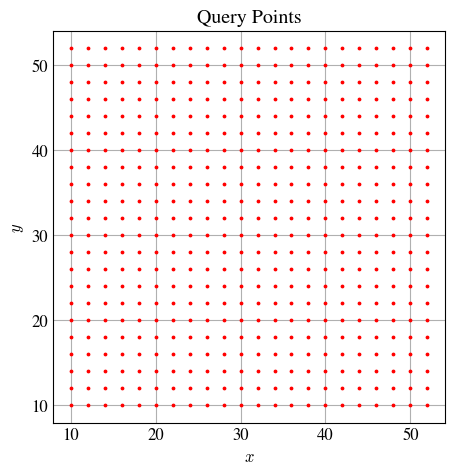


Sequential 'alpha' detected. Using fast test function method...

Test Functions


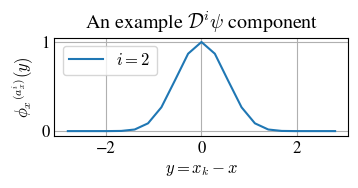

  0%|          | 0/10 [00:00<?, ?it/s]


Library computed with CPU.
The scaled data was used for MSTLS thresholding.

Optimal threshold(s) = [0.153]
Optimal loss(es) = [0.173]

Library shape: 7260 x 47
Library condition number: 2.314e+17.
scales = [[1.533], [0.529, 0.529], 0.667]
aux_scales = [0.666, 0.798]
p = [14.0, 14.0, 10.0]
s = (2, 2, 4)

Discovered model:
θ_t = (-2.77)(θ^2)_x + (-3.30)(θ)_y + (-2.74)(θ^2)_y
Sparse model explains [96.18]% of the data's variance.


In [ ]:
# Grid parameters
(dx, dy, dt) = (1., 1., 0.075)
(Lx, Ly, T) = (62., 62., 7.425)

# Function library
#fields = 6
fields = 3
powers = 2
poly = get_poly(powers, fields, max_power=2)
trig = ()
fj = {'poly': poly, 'trig': trig}

# Derivative library
lhs = ((0,0,1),) # D^0 = d/dt
dimension = 2
pure_derivs = 2
cross_derivs = 0
rhs = get_alpha(dimension, pure_derivs, cross_derivs)
alpha = lhs + rhs

params = {
    # PDE PARAMETERS
    # x = spatial domain(s)
    # dx = spatial discretization(s)
    # t = temporal domain
    # dt = temporal discretization
    # aux_fields = extra library variables
    # aux_scales = scaling factors for aux fields
    #--------------------------------------------
    'x' : [(0, Lx), (0, Ly)],
    'dx' : [dx, dy],
    't' : (0, T),
    'dt' : dt,
    #'aux_fields' : [U, V, W, Tempz, Wz/2.5],
    'aux_fields' : [U, V],

    # WEAK SINDY HYPERPARAMETERS
    # m = explicit (mx,...,mt) values
    # s = explicit (sx,...,st) values
    # lambdas = MSTLS threshold search space
    # threshold = known optimal threshold
    # p = explicit (px,...,pt) values
    # tau = test function tolerance
    # tau_hat = Fourier test function tolerance
    # scales = explicit ([yu],[yx],yt) scaling factors
    # M = explicit scaling matrix
    #-------------------------------------------------
    #'tau_hat' : 3,
    'm' : [10, 10, 20],

    # MISCELLANEOUS
    # verbosity = report info and create plots? (0 or 1)
    # init_guess = [x0, y0, m1, m2], for (kx,kt) curve fit
    # max_its = specify maximum number of MSTLS iterations
    # sigma_NR = noise ratio of artifical gaussian noise
    # sparsify = use 'original' or 'scaled' data in MSTLS
    # field_names = variable names, e.g., ['u','v','w']
    # augment = append operator? E.g., ('Div','2d_cartesian')
    #--------------------------------------------------------
    'verbosity' : 1,
    'sparsify' : 'scaled',
    #'field_names' : ['θ', 'u', 'v', 'w', 'z', 'η'],
    'field_names' : ['θ', 'u', 'v'],
    'sigma_NR' : 0.0,
    'augment' : ('Div', '2d_cartesian')}

# Run weak SINDy
w,L,b,r,pde = wsindy(Temp, fj, alpha, **params)

In [ ]:
print(f'Discovered coeffs: {w[11].item(), w[28].item(), w[29].item()}')

Discovered coeffs: (-2.7746187211566595, -3.297854570857185, -2.7375125505904854)


In [ ]:
# Save outputs:
# w = weights
# L = library
# b = lhs
# r = residuals
# pde = symbolic pde

import pandas as pd

SAVE_OUTPUT = False

output = {"w": [w.numpy().flatten()],
          "L": [L.numpy().flatten()],
          "b": [b.numpy().flatten()],
          "r": [r.flatten()],
          "pde": [pde]}

# Dataframe --> CSV
if SAVE_OUTPUT:
  output = pd.DataFrame(output)
  output.to_csv('wsindy_output_geophysical.csv', index=False)

del output

Residual analysis

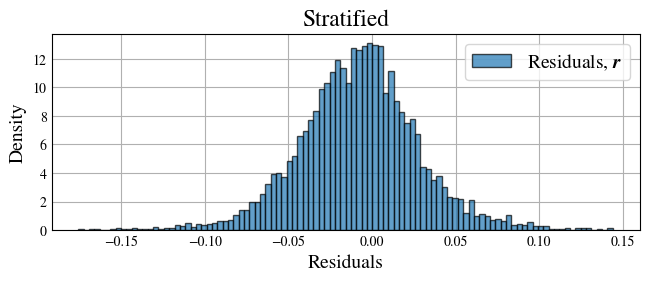

In [ ]:
# Plot the histogram
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14

plt.figure(figsize=(6,2))
plt.hist(r, bins=100, edgecolor='k', alpha=0.7, density=True,
         label='Residuals, $\\boldsymbol{r}$')
plt.title('Stratified')
plt.xlabel('Residuals')
plt.ylabel('Density')

plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.legend()
plt.show()

#### Momentum ($\boldsymbol{u}$)


Query Points


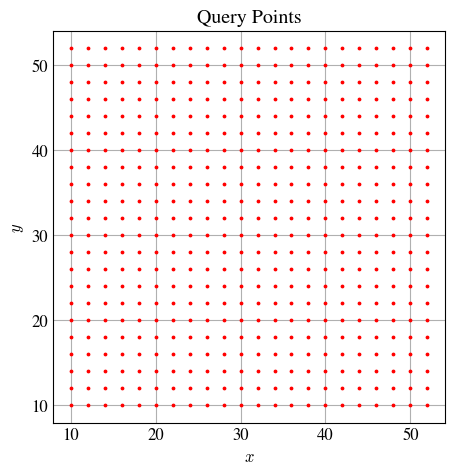


Sequential 'alpha' detected. Using fast test function method...

Test Functions


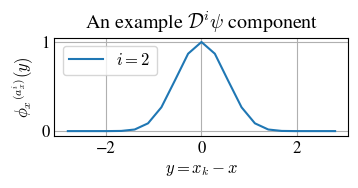

  0%|          | 0/10 [00:00<?, ?it/s]


Library computed with CPU.
The original data was used for MSTLS thresholding.

Optimal threshold(s) = [0.153]
Optimal loss(es) = [0.222]

Library shape: 7260 x 47
Library condition number: 4.678e+16.
scales = [[0.666], [0.529, 0.529], 0.667]
aux_scales = [0.798, 1.032]
p = [14.0, 14.0, 10.0]
s = (2, 2, 4)

Discovered model:
u_t = (4.72)(u)_x + (-0.61)(u^2)_x + (1.98)(v)_y + (-0.95)(uv)_y
Sparse model explains [95.85]% of the data's variance.


In [ ]:
# Grid parameters
(dx, dy, dt) = (1., 1., 0.075)
(Lx, Ly, T) = (62., 62., 7.425)

# Function library
#fields = 6
fields = 3
powers = 2
poly = get_poly(powers, fields, max_power=2)
trig = ()
fj = {'poly': poly, 'trig': trig}

# Derivative library
lhs = ((0,0,1),) # D^0 = d/dt
dimension = 2
pure_derivs = 2
cross_derivs = 0
rhs = get_alpha(dimension, pure_derivs, cross_derivs)
alpha = lhs + rhs

params = {
    # PDE PARAMETERS
    # x = spatial domain(s)
    # dx = spatial discretization(s)
    # t = temporal domain
    # dt = temporal discretization
    # aux_fields = extra library variables
    # aux_scales = scaling factors for aux fields
    #--------------------------------------------
    'x' : [(0, Lx), (0, Ly)],
    'dx' : [dx, dy],
    't' : (0, T),
    'dt' : dt,
    #'aux_fields' : [U, V, W, Tempz, Wz/2.5],
    'aux_fields' : [V, Px],

    # WEAK SINDY HYPERPARAMETERS
    # m = explicit (mx,...,mt) values
    # s = explicit (sx,...,st) values
    # lambdas = MSTLS threshold search space
    # threshold = known optimal threshold
    # p = explicit (px,...,pt) values
    # tau = test function tolerance
    # tau_hat = Fourier test function tolerance
    # scales = explicit ([yu],[yx],yt) scaling factors
    # M = explicit scaling matrix
    #-------------------------------------------------
    #'tau_hat' : 3,
    'm' : [10, 10, 20],

    # MISCELLANEOUS
    # verbosity = report info and create plots? (0 or 1)
    # init_guess = [x0, y0, m1, m2], for (kx,kt) curve fit
    # max_its = specify maximum number of MSTLS iterations
    # sigma_NR = noise ratio of artifical gaussian noise
    # sparsify = use 'original' or 'scaled' data in MSTLS
    # field_names = variable names, e.g., ['u','v','w']
    # augment = append operator? E.g., ('Div','2d_cartesian')
    #--------------------------------------------------------
    'verbosity' : 1,
    'sparsify' : 'original',
    'field_names' : ['u', 'v', 'p'],
    'sigma_NR' : 0,
    'augment' : ('Div', '2d_cartesian')}

# Run weak SINDy
w,L,b,r,pde = wsindy(U, fj, alpha, **params)


Query Points


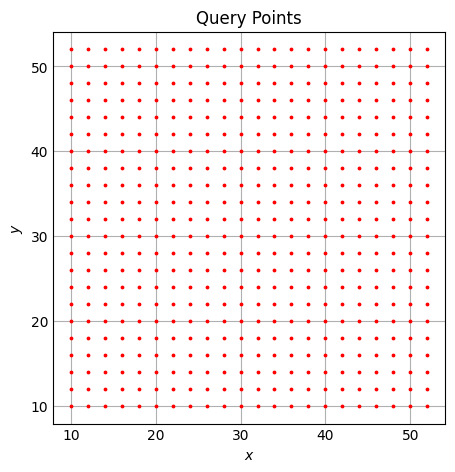


Sequential 'alpha' detected. Using fast test function method...

Test Functions


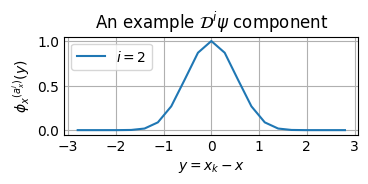

  0%|          | 0/10 [00:00<?, ?it/s]


Library computed with CPU.
The scaled data was used for MSTLS thresholding.

Optimal threshold(s) = [0.126]
Optimal loss(es) = [0.21]

Library shape: 7260 x 47
Library condition number: 5.898e+16.
scales = [[0.798], [0.529, 0.529], 0.667]
aux_scales = [0.666, 1.069]
p = [14.0, 14.0, 10.0]
s = (2, 2, 4)

Discovered model:
v_t = (3.20)(v)_x + (-0.66)(vu)_x + (0.21)(u^2)_x + (-0.56)(v^2)_y
Sparse model explains [94.46]% of the data's variance.


In [ ]:
# Grid parameters
(dx, dy, dt) = (1., 1., 0.075)
(Lx, Ly, T) = (62., 62., 7.425)

# Function library
#fields = 6
fields = 3
powers = 2
poly = get_poly(powers, fields, max_power=2)
trig = ()
fj = {'poly': poly, 'trig': trig}

# Derivative library
lhs = ((0,0,1),) # D^0 = d/dt
dimension = 2
pure_derivs = 2
cross_derivs = 0
rhs = get_alpha(dimension, pure_derivs, cross_derivs)
alpha = lhs + rhs

params = {
    # PDE PARAMETERS
    # x = spatial domain(s)
    # dx = spatial discretization(s)
    # t = temporal domain
    # dt = temporal discretization
    # aux_fields = extra library variables
    # aux_scales = scaling factors for aux fields
    #--------------------------------------------
    'x' : [(0, Lx), (0, Ly)],
    'dx' : [dx, dy],
    't' : (0, T),
    'dt' : dt,
    #'aux_fields' : [U, V, W, Tempz, Wz/2.5],
    'aux_fields' : [U, Py],

    # WEAK SINDY HYPERPARAMETERS
    # m = explicit (mx,...,mt) values
    # s = explicit (sx,...,st) values
    # lambdas = MSTLS threshold search space
    # threshold = known optimal threshold
    # p = explicit (px,...,pt) values
    # tau = test function tolerance
    # tau_hat = Fourier test function tolerance
    # scales = explicit ([yu],[yx],yt) scaling factors
    # M = explicit scaling matrix
    #-------------------------------------------------
    #'tau_hat' : 3,
    #'m' : [16, 16, 16], # seems pretty good
    'm' : [10, 10, 20],

    # MISCELLANEOUS
    # verbosity = report info and create plots? (0 or 1)
    # init_guess = [x0, y0, m1, m2], for (kx,kt) curve fit
    # max_its = specify maximum number of MSTLS iterations
    # sigma_NR = noise ratio of artifical gaussian noise
    # sparsify = use 'original' or 'scaled' data in MSTLS
    # field_names = variable names, e.g., ['u','v','w']
    # augment = append operator? E.g., ('Div','2d_cartesian')
    #--------------------------------------------------------
    'verbosity' : 1,
    'sparsify' : 'scaled',
    'field_names' : ['v', 'u', 'p'],
    'sigma_NR' : 0,
    'augment' : ('Div', '2d_cartesian')}

# Run weak SINDy
w,L,b,r,pde = wsindy(V, fj, alpha, **params)

#### Divergence $(\nabla \cdot \boldsymbol{u})$


Query Points


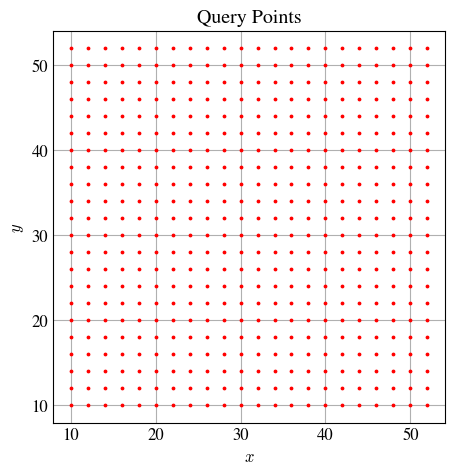


Sequential 'alpha' detected. Using fast test function method...

Test Functions


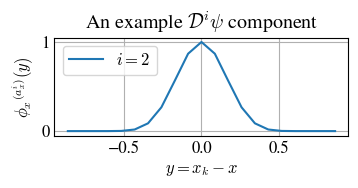

  0%|          | 0/2 [00:00<?, ?it/s]


Library computed with CPU.
The scaled data was used for MSTLS thresholding.

Optimal threshold(s) = [0.126]
Optimal loss(es) = [0.333]

Library shape: 7260 x 4
Library condition number: 1.735e+01.
scales = [[0.666], [0.293, 0.293], 0.833]
aux_scales = [0.666]
p = [14.0, 14.0, 10.0]
s = (2, 2, 4)

Discovered model:
v_y = (0.18)(u)
Sparse model explains [48.454]% of the data's variance.


In [ ]:
# Grid parameters
(dx, dy, dt) = (1., 1., 0.075)
(Lx, Ly, T) = (62., 62., 7.425)

# Function library
fields = 2
powers = 1
poly = get_poly(powers, fields, max_power=1)
poly = (poly[0],) + poly[2:] # Remove u for u_x
trig = ()
fj = {'poly': poly, 'trig': trig}

# Derivative library
lhs = ((0,1,0),) # D^0 = d/dx
dimension = 2
pure_derivs = 1
cross_derivs = 0
rhs = get_alpha(dimension, pure_derivs, cross_derivs)
alpha = lhs + rhs

params = {
    # PDE PARAMETERS
    # x = spatial domain(s)
    # dx = spatial discretization(s)
    # t = temporal domain
    # dt = temporal discretization
    # aux_fields = extra library variables
    # aux_scales = scaling factors for aux fields
    #--------------------------------------------
    'x' : [(0, Lx), (0, Ly)], # trimmed
    'dx' : [dx, dy],
    't' : (0, T),
    'dt' : dt,
    #'aux_fields' : [V, W, Wz/2],
    'aux_fields' : [U],
    'aux_scales' : [0.666],

    # WEAK SINDY HYPERPARAMETERS
    # m = explicit (mx,...,mt) values
    # s = explicit (sx,...,st) values
    # lambdas = MSTLS threshold search space
    # threshold = known optimal threshold
    # p = explicit (px,...,pt) values
    # tau = test function tolerance
    # tau_hat = Fourier test function tolerance
    # scales = explicit ([yu],[yx],yt) scaling factors
    # M = explicit scaling matrix
    #-------------------------------------------------
    #'tau_hat' : 3,
    'm' : [10, 10, 20],
    'scales' : ([0.666], [0.293, 0.293], 0.833),

    # MISCELLANEOUS
    # verbosity = report info and create plots? (0 or 1)
    # init_guess = [x0, y0, m1, m2], for (kx,kt) curve fit
    # max_its = specify maximum number of MSTLS iterations
    # sigma_NR = noise ratio of artifical gaussian noise
    # sparsify = use 'original' or 'scaled' data in MSTLS
    # field_names = variable names, e.g., ['u','v','w']
    # augment = append operator? E.g., ('Div','2d_cartesian')
    #--------------------------------------------------------
    'verbosity' : 1,
    'sparsify' : 'scaled',
    #'field_names' : ['u', 'v', 'w', 'η'],
    'field_names' : ['v', 'u'],
    'sigma_NR' : 0}

# Run weak SINDy
w,L,b,r,pde = wsindy(V, fj, alpha, **params)